## Problem Set 5, Solution
**Stats 507, Fall 2021**  
*James Henderson, PhD*  
*November 5, 2021*


## Contents
+ [Question 0](#Question-0)
+ [Question 1](#Question-1)
+ [Question 2](#Question-2)


## Imports
We will use the following imports in this assignment.

In [1]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.formula.api as smf
from os.path import exists
from scipy.stats import logistic, norm
# 79: -------------------------------------------------------------------------

In [2]:
# style figures: --------------------------------------------------------------
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.titlesize': 'x-large'}
pylab.rcParams.update(params)

## Question 0
In this question you fit a model and demonstrate how to compute the
R-squared and adjusted R-squared for that model.

First, we load the data (this can be
copied directly from the slides). 

In [3]:
# tooth growth data
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)

Now we log transform length and create 
categorical versions of the covariates.

In [4]:
# prepare data for modeling
tg_data['log_len'] = tg_data[['len']].transform(np.log)
tg_data['supp'] = pd.Categorical(tg_data['supp'])
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

Next we fit the specified model.

In [5]:
mod1 = sm.OLS.from_formula('log_len ~ supp*dose', data=tg_data)
res1 = mod1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_len   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     40.26
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           5.28e-14
Time:                        16:41:31   Log-Likelihood:                -8.6829
No. Observations:                  60   AIC:                             25.37
Df Residuals:                      56   BIC:                             33.74
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.4583      0.112     21.928      0.000       2.234       2.683
supp[T.VC]         -0.6564      0.159     -4.140      0.000      -0.974      -0.339
dose                0.4345      0.085      5.127      0.000       0.265       0.604
supp[T.VC]:dose     0.3294      0.120      2.748      0.008       0.089       0.569
==============================================================================
Omnibus:                        2.645   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.575
Skew:                          -0.469   Prob(JB):                        0.276
Kurtosis:                       2.613   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The $R^2$ value is the proportion of explained variance.
We can compute that using the *explained sum of squares*
(`ess`) and *sum of squared residuals* attributes (`ssr`).
We use an assertion to check that our computation matches the
existing attribute.

In [6]:
r_sq = 1 - res1.ssr / (res1.ess + res1.ssr)
assert np.allclose(res1.rsquared, r_sq)

The adjusted $R^2$ penalizes the $R^2$ based on the 
number of parameters in the model.  It can be estimated
by dividing each sum of squares by the respective degrees
of freedom.

In [7]:
r_sq_adj = 1 - (res1.ssr / res1.df_resid ) / (
    (res1.ess + res1.ssr) / (res1.nobs - 1)
)
assert np.allclose(res1.rsquared_adj, r_sq_adj)

## Question 1

### Probability of a Permanent Tooth by Age

In this question we model the probability of a permanent tooth being present
as a function of age using the NHANES data and logistic regression. 

### part a) 
In this part we load the data, choose a specific tooth, and model
the probability that an individual has a permanent tooth present at
that position. 

In [8]:
# read data: ------------------------------------------------------------------
# NHANES demographics 
demo_file = 'demo.feather'
demo = pd.read_feather(demo_file)

# NHANES dentition
ohx_file = 'ohx.feather'
ohx = pd.read_feather(ohx_file)


The code below is taken from PS4 to create demographics we can use
for modelling. 

In [9]:
# merge dentition exam status into demo
n0 = demo.shape[0]
df = pd.merge(demo, ohx, on='id', how='left')
df.rename(columns={'dentition_status': 'ohx_status'}, inplace=True)
assert n0 == df.shape[0]

# missingness
df['ohx'] = np.logical_and(
    df['ohx_status'] == 'Complete', 
    df['exam_status'] == 'Both interviewed and MEC examined'
)
df['ohx'] = df['ohx'].replace({True: 'Complete', False: 'Missing'})
df['ohx'] = pd.Categorical(df['ohx'])

# derived variables
df['under_20'] = df['age'] < 20

college = ('College graduate or above', 'Some college or AA degree')
df['college'] = np.logical_or(
    df['education'].apply(lambda x: x in college).replace({np.nan: False}),
    df['under_20']
)
df['college'] = df['college'].replace(
    {True: 'Some College/College Graduate',
     False: 'No College/<20'
    })
df['college'] = pd.Categorical(df['college'])

df['under_20'] = (
    df['under_20']
    .replace({True: '<20 years old', False: '20+ years old'})
)

Next we drop those whom were interviewed only and then
limit to those who completed the dentition exam. 

In [10]:
# drop those not given any medical exams
df = df.query('exam_status == "Both interviewed and MEC examined"')
df_ohx = df.query('ohx == "Complete"').copy()
df_ohx.set_index('id', inplace=True)

Before modeling the probability that a pernament tooth is present
in a specific position as a function of age and other factor, I
investigate how the dependence on age looks in the data marginalized
across other demographics.

In [11]:
# construct a DataFrame of indicators for a present permanent tooth
tc_vars = ['tc_' + str(i).zfill(2) for i in range(1, 33)]
y_vars = ['y_' + str(i).zfill(2) for i in range(1, 33)]
y_series = {v: None for v in y_vars}
for i in range(32):
    y_series.update(
        {y_vars[i]: 1 * (df_ohx[tc_vars[i]] == 'Permanent tooth present')}
    )
y_df = pd.DataFrame(y_series).reset_index()

Now merge those indicators back into the primary data. 

In [12]:
df_ohx = pd.merge(
    df_ohx, 
    y_df,
    how='left',
    on='id'
)

Compute the marginal proportions by age.

In [13]:
p_hat = df_ohx.groupby('age')[y_vars].mean()
#p_hat.head()

For each tooth, find the first age where the
marginal proportion is greater than 0 and the 
age at which the proportions peak. 

In [14]:
# find minimum and peak ages
min_age = {}
peak_age = {}
# subtract max so peak age is associated with zero
p_max = p_hat.transform(lambda x: x - np.max(x))

for y in y_vars:
    # minimum age at which permanent tooth appears
    age = (
        p_hat[[y]]
        .reset_index()
        .query(y + ' > 0')
        .iloc[0, 0]
    )
    min_age.update({y: age})
    
    # age at which present of permanent tooth peaks
    age = (
        p_max[[y]]
        .reset_index()
        .query(y + ' == 0')
        .iloc[0, 0]
    )
    peak_age.update({y: age})

Here we divide the mouth into quadrants and assign a name
to each tooth using the [Universal Numbering System][tnum].
This will make it easier to visualize the teeth in a coherent
way.

[tnum]: https://www.news-medical.net/health/Universal-Numbering-System-for-Teeth.aspx

In [15]:
# tooth names and mouth quadrant: ---------------------------------------------
position = (
    list(range(1, 9)) +
    list(reversed(range(9, 17))) +
    list(range(17, 25)) +
    list(reversed(range(25, 33)))
)
tooth_names = (
    '3rd Molar', '2nd Molar', '1st molar', 
    '2nd biscuspid', '1st bicuspid', 'cuspid',
    'lateral incisor', 'central incisor')
areas = ('upper right', 'upper left', 'lower left', 'lower right')

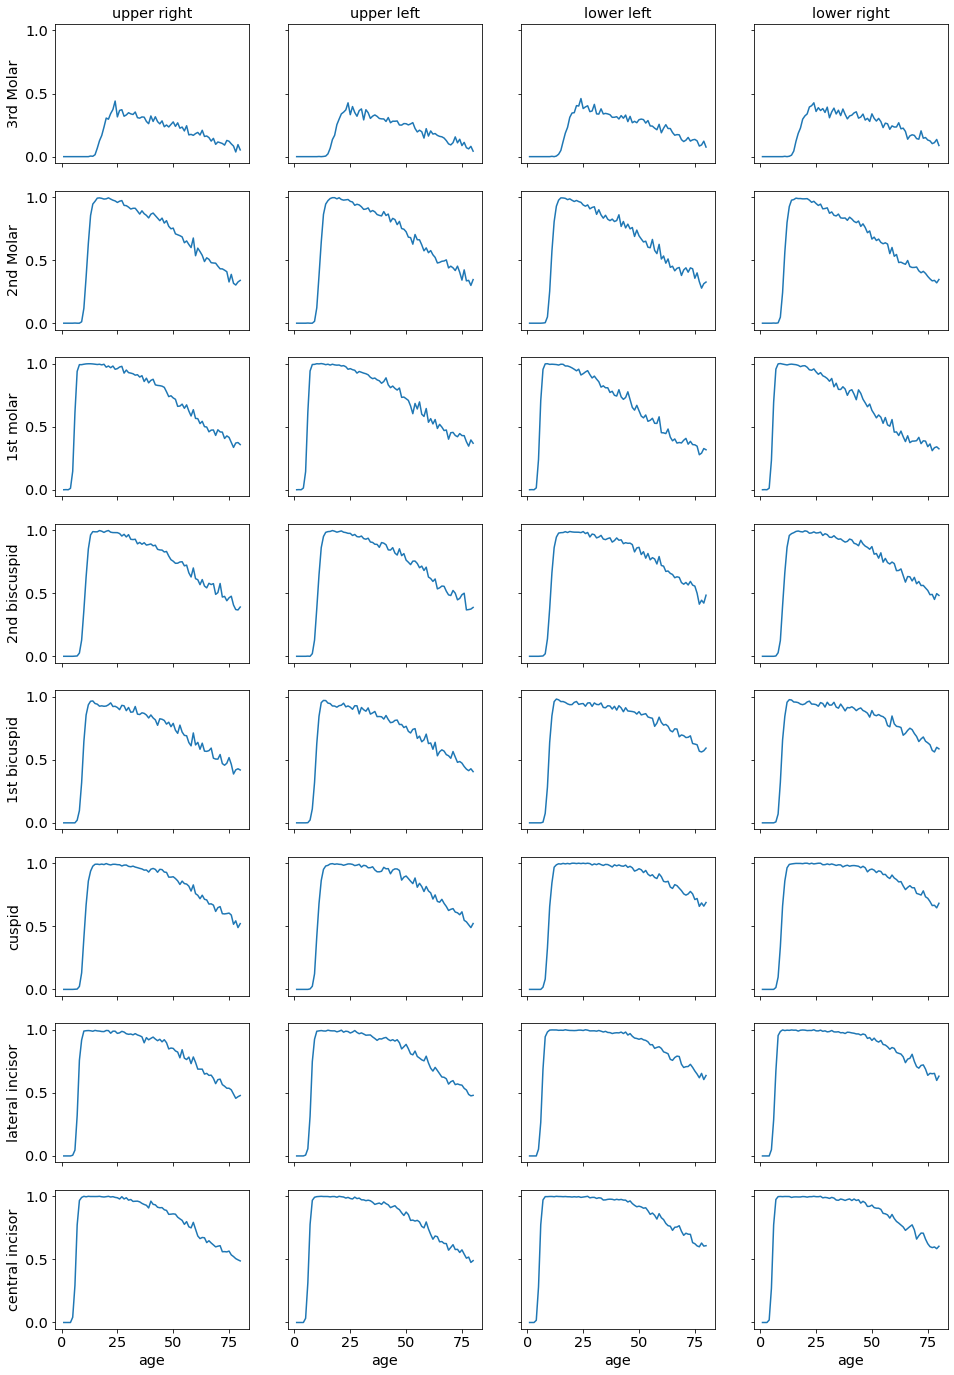

In [16]:
# visualize the marginal proportions: -----------------------------------------
fig, ax = plt.subplots(nrows=8, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(16, 24)
for i in range(32):
    r = (position[i] - 1) % 8
    c = i // 8
    (p_hat[y_vars[i]]
     .plot
     .line(ax=ax[r, c])
    )
    if r == 0:
        ax[r, c].set_title(areas[c])
    if c == 0:
        ax[r, c].set_ylabel(tooth_names[r])

Now we can do some model building. I'm going to focus on tooth 9.

In [17]:
mod0 = smf.logit('y_09 ~ bs(age, df=6, degree=3)', data=df_ohx)
res0 = mod0.fit()
res0.summary()
df_ohx['yhat0_09'] = mod0.predict(params=res0.params)

Optimization terminated successfully.
         Current function value: 0.269991
         Iterations 11


(18567.775683124968, 6.0)

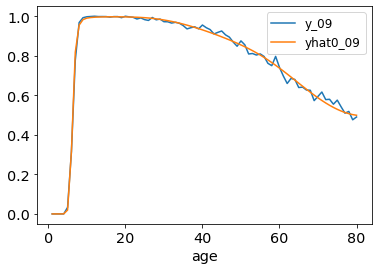

In [18]:
(df_ohx
 .groupby('age')[['y_09', 'yhat0_09']]
 .mean()
 .plot
 .line()
)
(res0.aic, res0.df_model)

Based on the results, I'll choose specific locations for knots.

In [19]:
mod1 = smf.logit(
    'y_09 ~ bs(age, knots=(6, 12, 20, 40, 60), degree=3)',
     data=df_ohx
)
res1 = mod1.fit()
(res1.aic, mod1.df_model)

Optimization terminated successfully.
         Current function value: 0.269299
         Iterations 18


(18524.21626103933, 8.0)

Can we use fewer knots on the downslope at older ages?

In [20]:
mod2 = smf.logit(
    'y_09 ~ bs(age, knots=(6, 12, 20, 50), degree=3)',
     data=df_ohx
)
res2 = mod2.fit()
(res2.aic, mod2.df_model)

Optimization terminated successfully.
         Current function value: 0.269444
         Iterations 18


(18532.169074109235, 7.0)

Should we place the lowest knot closer to the peak?

In [21]:
(min_age['y_09'], peak_age['y_09'])

(5, 12)

In [22]:
mod3 = smf.logit(
    'y_09 ~ bs(age, knots=(8.5, 12, 20, 50), degree=3)',
     data=df_ohx
)
res3 = mod3.fit()
(res3.aic, mod3.df_model)

Optimization terminated successfully.
         Current function value: 0.269367
         Iterations 13


(18526.90618718537, 7.0)

We may be able to make small improvments, but the knot
sequence used in model 1 compares favorably to models
0, 2, and 3.

In [23]:
[np.round(i, 1) for i in (res0.aic, res1.aic, res2.aic, res3.aic)]

[18567.8, 18524.2, 18532.2, 18526.9]

### Demographics
Next, I'll explore which demographics - if any - improve the AIC.


In [24]:
## gender
assert df_ohx['gender'].count() == df_ohx.shape[0]
f0 = 'y_09 ~ bs(age, knots=(6, 12, 20, 40, 60), degree=3)'
mod1_a = smf.logit(
     f0 + ' + gender',
     data=df_ohx
)
res1_a = mod1_a.fit()
(res1_a.aic, res1.aic)

Optimization terminated successfully.
         Current function value: 0.268841
         Iterations 18


(18494.773933778713, 18524.21626103933)

In [25]:
# some college
assert df_ohx['college'].count() == df_ohx.shape[0]
mod1_b = smf.logit(
    f0 + ' + gender + college',
     data=df_ohx
)
res1_b = mod1_b.fit()
(res1_b.aic, res1_a.aic)

Optimization terminated successfully.
         Current function value: 0.260720
         Iterations 18


(17938.677255001006, 18494.773933778713)

In [26]:
# marital status
df_ohx['married'] = pd.Categorical(
    np.where(
        df_ohx['marital_status'] == 'Married',
        'Married',
        'Unmarried/refused'
    )
)
assert df_ohx['married'].count() == df_ohx.shape[0]

mod1_c = smf.logit(
    f0 + ' + gender + college + married',
     data=df_ohx
)
res1_c = mod1_c.fit()
(res1_c.aic, res1_b.aic)

Optimization terminated successfully.
         Current function value: 0.258661
         Iterations 18


(17799.15417003776, 17938.677255001006)

Each of gender, "some college" and "married" improve AIC.
We could continue to explore, but this will suffice.

### part b
In part *b* we fit a model similar to that above to each tooth.
One ariation I make to the sequence of knots used to model age;
the location of the lowest knot and a knot at the "peak" are 
place in tooth-specific ways. Before fitting the models, I create 
a function for returning confidence bounds in an easy-to-work-with
tuple format.

In [27]:
def ci_glm(v, df, formula, level=0.95, inv_link=None):
    """
    Compute confidence intervals for predictions from a GLM.
    
    Parameters
    ----------
     v - 2D NumPy array.
       The variance-covariance matrix from the fitted glm.
       Usually returned as res.cov_params() where res is the
       fitted model. 
    df - DataFrame.
      This DataFrame is passed as the data argument to smf.ols
      in order to construct the desing matrix for the predictions.
    formula - str.
      The formula passed to smf.ols, which, with df above, is used
      to construct the desing matrix for the predictions.
    level - double, optional.
      The confidence level desired. The default is 0.95. 
    inv_link - function or None, optional.
      If None the confidence interval is returned on the scale of
      the linear predictor. Otherwise this function is applied to
      the lower and upper buonds. 
      
    Returns
    -------
    A tuple with lower and upper bounds, each a 1D NumPy array
    of length equal to the number of rows in the input data `df`. 
    """    
    # construct model matrix for predictions
    ci_mod = smf.ols(formula, data=df)
    X = ci_mod.exog
    # linear predictor
    lp = np.dot(X, r.params)
    # standard error 
    v = r.cov_params()
    se = np.sqrt(np.diag(np.dot(np.dot(X, v), X.T)))
    # confidence bounds on desired scale
    z = norm.ppf(1 - (1 - level) / 2)
    if inv_link is None:
        est = lp
        lwr, upr = lp - z * se, lp + z * se
    else:
        est = inv_link(lp)
        lwr, upr = inv_link(lp - z * se), inv_link(lp + z * se)
    return((est, lwr, upr))

Now we're ready to fit the models. I'm going to create data for part 
c as part of the iterations here. To do that, I'll crate an empty data
frame with unique values for all the predictors.

In [28]:
df_age = pd.DataFrame(
    { 'y': [0] * 80 * 8,
      'age': list(range(1, 81)) * 8,
      'gender': (80 * ['Female'] + 80 * ['Male']) * 4,
      'college': (
          2 * 80 * ['No College/<20'] + 
          2 * 80 * ['Some College/College Graduate']
      ) * 2,
      'married': (
          4 * 80 * ['Married'] + 4 * 80 *['Unmarried/refused']
      )
    }
)
for v in ('gender', 'college', 'married'):
    df_age[v] = pd.Categorical(df_age[v])


In [29]:
# 79: -------------------------------------------------------------------------
# fit a model to each tooth
rhs_template = '~ bs(age, knots={}, degree=3) + gender + college + married'
models = []
df_list = []
# loop over teeth
for i in range(1, 33):
    y = y_vars[i - 1]
    # construct a sensible knot sequence
    knots = '('
    k0, k1 = min_age[y], peak_age[y]
    knots = [k0, k1, 6, 12, 20, 40, 60]
    knots.sort()
    k_tuple = '('
    for k in knots:
        if k > k0 and k != k1 and k < max(knots):
            k_tuple += str(k) + ', '
        elif k > k1:
            k_tuple += str(k) + ')'
    # specify knots to formula
    rhs = rhs_template.format(k_tuple)
    # setup and fit the model
    m = smf.logit(y + rhs, data=df_ohx)
    r = m.fit(disp=False)
    models.append((m, r))
    # predicted means and CI
    t = str(i).zfill(2)
    y_hat, y_lwr, y_upr = 'yhat_' + t, 'lwr_' + t, 'upr_' + t
    df_ohx[y_hat] = m.predict(r.params)
    # this is for part c
    v = r.cov_params()
    est, lwr, upr = ci_glm(v, df_age, 'y' + rhs, inv_link=logistic.cdf)
    df_list.append(pd.DataFrame({y_hat: est, y_lwr: lwr, y_upr: upr}))

df_pred = pd.concat([df_age] + df_list, axis=1).copy()
# 79: -------------------------------------------------------------------------


/var/folders/5b/8m5r4m2d50z9ypn24v5l30_m0000gn/T/ipykernel_50166/2480668662.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ohx[y_hat] = m.predict(r.params)


## part c
In this part, we visualize the dependence on age for each tooth. 
Initially, I'll do this for the model reference group of an unmarried
male who has some college or is a college graduate. 

In [30]:
qry0 = (
    'gender == "Male" and ' +
    'college == "Some College/College Graduate" and ' +
    'married == "Unmarried/refused"'
)
p_hat_ref = (
    df_ohx
    .query(qry0)
    .groupby('age')[y_vars]
    .mean()
)
df_pred_ref = df_pred.query(qry0)
df_pred_ref = df_pred_ref.sort_values('age')

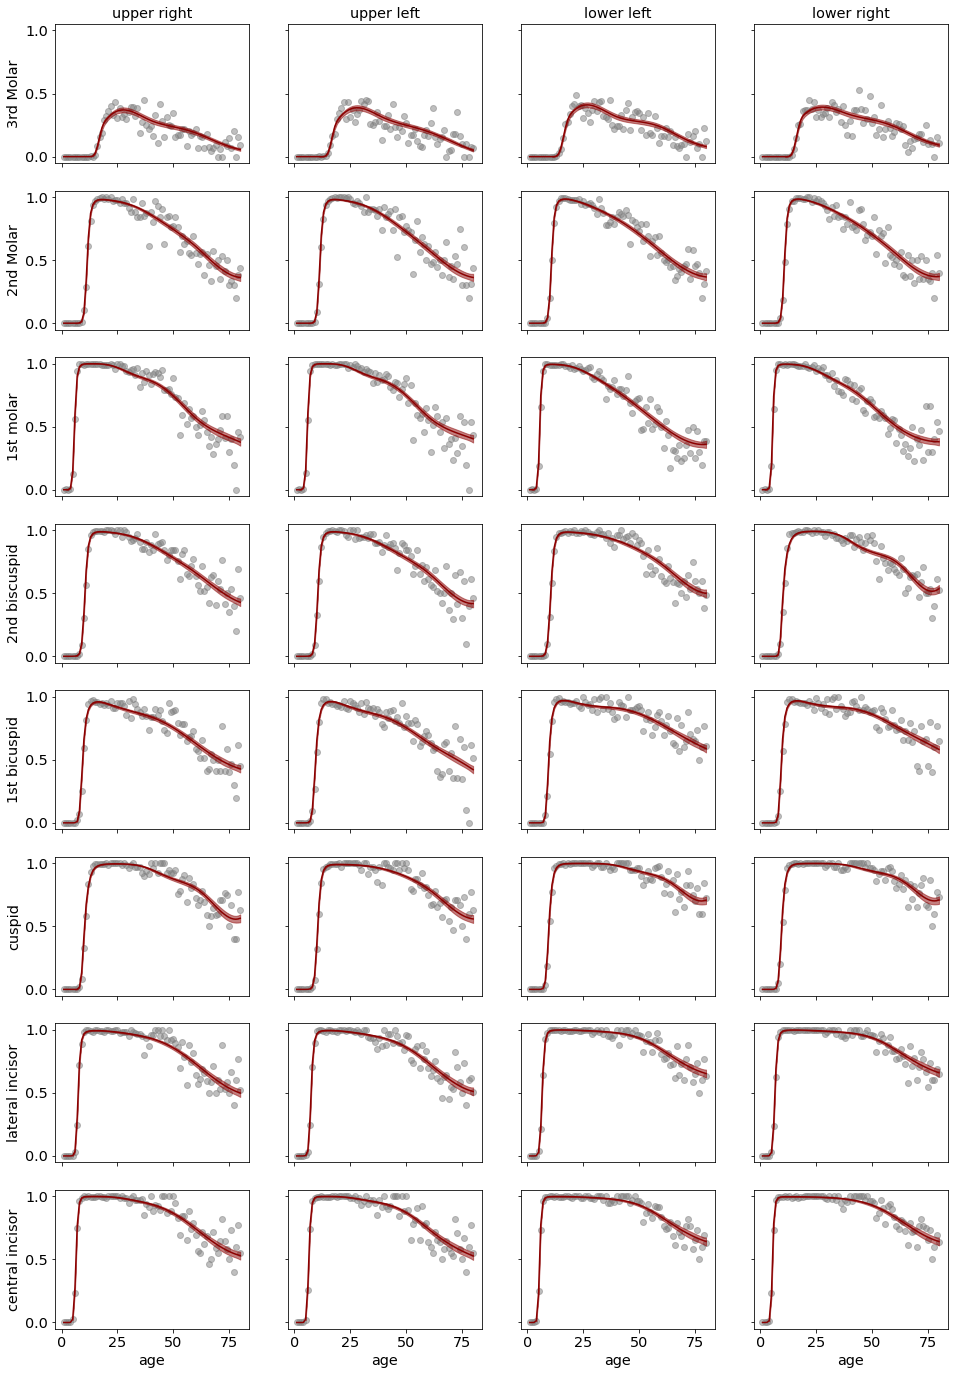

In [31]:
# construct a figure for the reference group: ---------------------------------
fig2, ax2 = plt.subplots(nrows=8, ncols=4, sharex=True, sharey=True)
fig2.set_size_inches(16, 24)
p_hat_ref = p_hat_ref.reset_index()
for i in range(32):
    # columns
    t = str(i + 1).zfill(2)
    y_hat, y_lwr, y_upr = 'yhat_' + t, 'lwr_' + t, 'upr_' + t
    # subset to ages above first appearance
    y = 'y_' + t
    qry = 'age >= ' + str(min_age[y])
    # subplot position
    r = (position[i] - 1) % 8
    c = i // 8
    # data average
    ax2[r, c].scatter(
        x=p_hat_ref['age'],
        y=p_hat_ref[y_vars[i]],
        alpha=0.5,
        color='grey'
    )
    # confidence bounds
    ax2[r, c].fill_between(
        x=df_pred_ref.query(qry)['age'],
        y1=df_pred_ref.query(qry)[y_lwr],
        y2=df_pred_ref.query(qry)[y_upr],
        alpha=0.5,
        color='darkred'
    )
    # model expected value
    (df_pred_ref
     .plot
     .line(
         ax=ax2[r, c],
         x='age',
         y=y_hat,
         color='darkred',
         legend=None
     )
    )
    if r == 0:
        ax2[r, c].set_title(areas[c])
    if c == 0:
        ax2[r, c].set_ylabel(tooth_names[r])

## Question 2
In this question we construct a Hosmer-Lemeshow calibration plot.
This plot shows the expected vs empirical probabilities in groups
based on quantiles (here deciles) of the expected probabilities.

In [32]:
# data for HL plot: -----------------------------------------------------------
hl_data = df_ohx[['y_09', 'yhat_09']]
#hl_data['decile'] = pd.qcut(hl_data['yhat_09'], 10)
hl_data = (
    hl_data
    .groupby(pd.qcut(hl_data['yhat_09'], 10))
    .mean()
)

In [33]:
# clean-up bounds on cuts: ----------------------------------------------------
cuts = hl_data.index.categories
cuts = [
    pd.Interval(max(0, i.left), min(1, i.right)) for i in cuts
]
cuts[9] = pd.Interval(cuts[9].left, 1)
hl_data.index = cuts

In [34]:
hl_data.columns = ['Observed', 'Expected']
hl_data

,Observed,Expected
"(0.0, 0.0004518]",0.000000,0.000090
"(0.0004518, 0.4924]",0.307533,0.306674
"(0.4924, 0.6954]",0.605766,0.605298
"(0.6954, 0.8136]",0.754564,0.758686
"(0.8136, 0.9079]",0.860438,0.859335
"(0.9079, 0.9576]",0.935673,0.936959
"(0.9576, 0.9832]",0.973631,0.970523
"(0.9832, 0.9957]",0.991806,0.990153
"(0.9957, 0.999]",0.997693,0.998072
"(0.999, 1.0]",0.997788,0.999299


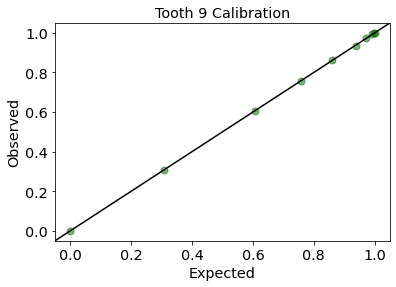

In [35]:
ax3 = (hl_data
 .plot
 .scatter(x='Expected', y='Observed', s=48, alpha=0.5, color='darkgreen')
)
_ = ax3.set_title('Tooth 9 Calibration')
_ = ax3.axline((0, 0), slope=1, color='black')

The probabilities are very well calibrated as evidence by equality
between the average expected and observed probability within each 
decile.  We are, however,averaging over a wide swath of probability
space in the second and third buckets from the left, oweing to a 
relative scaricity of observations with expected probability between
(5e-5 and 0.69]. 

In [36]:
# data for alternate HL plot: -------------------------------------------------
hl_data2 = df_ohx[['y_09', 'yhat_09']]
n = (
    hl_data2
    .groupby(pd.cut(hl_data2['yhat_09'], np.arange(0, 1.1, 0.1)))
    .size()
)
hl_data2 = (
    hl_data2
    .groupby(pd.cut(hl_data2['yhat_09'], np.arange(0, 1.1, 0.1)))
    .mean()
)
hl_data2['n'] = n
hl_data2.columns = ['Observed', 'Expected', 'n']
hl_data2.index.name = ''
hl_data2

,Observed,Expected,n
,,,
"(0.0, 0.1]",0.005615,0.005090,4274
"(0.1, 0.2]",NaN,NaN,0
"(0.2, 0.3]",0.258907,0.287589,421
"(0.3, 0.4]",0.347064,0.352919,1141
"(0.4, 0.5]",0.469922,0.453192,1147
"(0.5, 0.6]",0.567515,0.555204,1533
"(0.6, 0.7]",0.642857,0.653987,1904
"(0.7, 0.8]",0.746996,0.753491,2913
"(0.8, 0.9]",0.849971,0.848286,3506


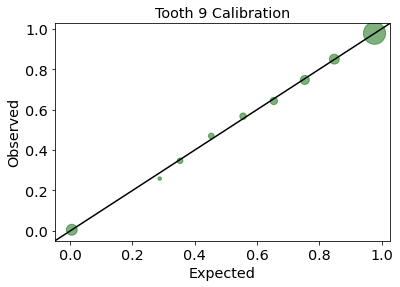

In [37]:
s = n / np.sum(n) * 480 * 2
ax4 = (hl_data2
 .plot
 .scatter(x='Expected', y='Observed', s=s, alpha=0.5, color='darkgreen')
)
_ = ax4.set_title('Tooth 9 Calibration')
_ = ax4.axline((0, 0), slope=1, color='black')

This alternate version remains well-calibrated where we are 
able to assess.